In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle

In [2]:
high_management = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]  # red
middle_management = [76, 90, 136, 137, 143, 152, 47, 162]  # blue

In [3]:
communication = pd.read_csv("data/communication.csv", sep=";")
reportsto = pd.read_csv("data/reportsto.csv", sep=";")

In [4]:
def cast_to_int_if_possible(row):
    try:
        int_val = int(row)
        return int_val
    except:
        if row == 'technical email account - not used by employees':
            return -1
        elif row == 'former employee account':
            return -2

reportsto['ReportsToID'] = reportsto['ReportsToID'].apply(lambda row: cast_to_int_if_possible(row))

In [5]:
print(communication.shape)
print(reportsto.shape)

(82927, 3)
(167, 2)


In [6]:
communication.head()

,Sender,Recipient,EventDate
0,17,37,2010-01-02 17:40:10
1,17,136,2010-01-02 17:40:10
2,17,62,2010-01-02 17:40:10
3,17,129,2010-01-02 17:40:10
4,17,32,2010-01-02 17:40:10


In [7]:
reportsto.head()

,ID,ReportsToID
0,1,152
1,2,132
2,3,152
3,4,-1
4,5,36


In [8]:
def get_edges(df: pd.DataFrame):
    edges = []
    for row in df.values.tolist():
        edges.append((row[0], row[1], {'reportsto': True}))
    return edges


def get_edges_with_attibutes(df: pd.DataFrame):
    edges = []
    for group, row in communication.groupby(by=["Sender", "Recipient"]):
        edges.append((group[0], group[1], {'num_mails': row["Sender"].count()}))
    return edges

# Reportsto graph

In [9]:
G_reportsto = nx.Graph()
G_reportsto.add_nodes_from(reportsto["ID"].values.tolist())
G_reportsto.add_edges_from(get_edges(reportsto))

In [10]:
print(len(G_reportsto.nodes))
print(len(G_reportsto.edges))

169
167


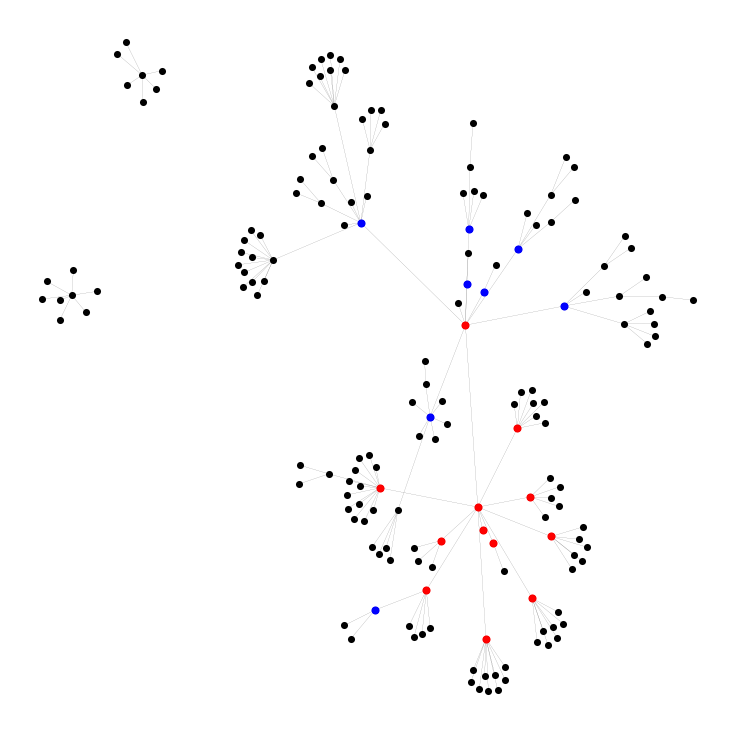

In [11]:
options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_reportsto)
nx.draw(G_reportsto, pos, with_labels=False, **options)

nx.draw_networkx_nodes(G_reportsto, pos,
                       nodelist=high_management,
                       node_color='r',
                       node_size=50)
nx.draw_networkx_nodes(G_reportsto,pos,
                       nodelist=middle_management,
                       node_color='b',
                       node_size=50)

# Communication graph

In [12]:
G_communication = nx.Graph()
G_communication.add_nodes_from(communication["Sender"].values.tolist())
G_communication.add_edges_from(get_edges_with_attibutes(communication))

In [13]:
print(len(G_communication.nodes))
print(len(G_communication.edges))

167
3251


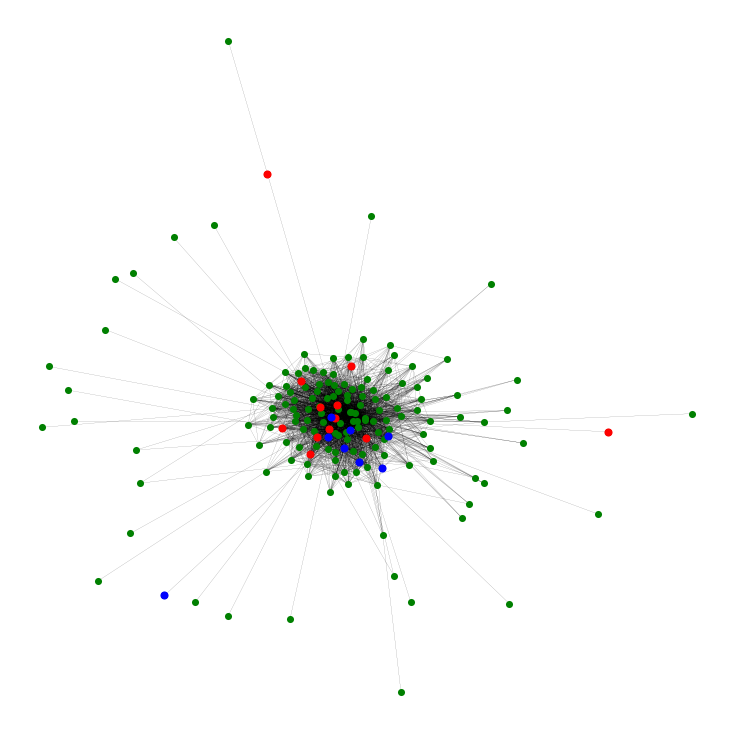

In [14]:
options = {
    'node_color': 'green',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_communication)
nx.draw(G_communication, pos, with_labels=False, **options)

nx.draw_networkx_nodes(G_communication, pos,
                       nodelist=high_management,
                       node_color='r',
                       node_size=50)
nx.draw_networkx_nodes(G_communication,pos,
                       nodelist=middle_management,
                       node_color='b',
                       node_size=50)

# Communication & reportsto graph

In [15]:
G_both = nx.Graph()
G_both.add_nodes_from(communication["Sender"].values.tolist())
G_both.add_edges_from(get_edges_with_attibutes(communication))
G_both.add_edges_from(get_edges(reportsto))

In [16]:
print(len(G_both.nodes))
print(len(G_both.edges))

169
3321


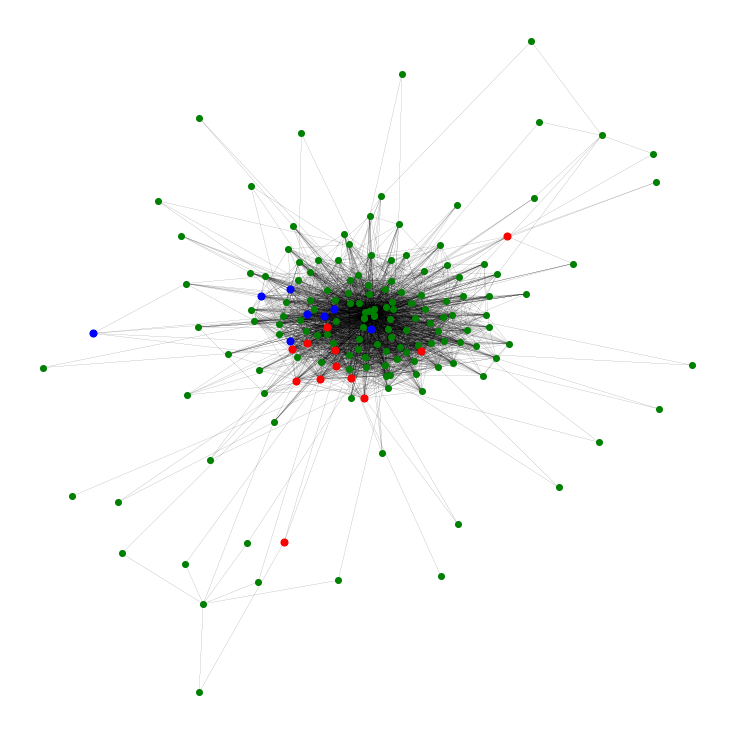

In [17]:
options = {
    'node_color': 'green',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_both)
nx.draw(G_both, pos, with_labels=False, **options)

nx.draw_networkx_nodes(G_both, pos,
                       nodelist=high_management,
                       node_color='r',
                       node_size=50)
nx.draw_networkx_nodes(G_both,pos,
                       nodelist=middle_management,
                       node_color='b',
                       node_size=50)

# Set true class attr

In [18]:
for G in [G_reportsto, G_communication, G_both]:
    attrs = {}
    for node in G.nodes:
        if node in high_management:
            attrs[node] = {'true_class': 2}
        elif node in middle_management:
            attrs[node] = {'true_class': 1}
        else:
            attrs[node] = {'true_class': 0}
        attrs[node]['node'] = node
    nx.set_node_attributes(G, attrs)

# Communication analysis

In [19]:
mail_nums = {}
for group, row in communication.groupby(by=["Sender", "Recipient"]):
    mail_nums[group] = row["Sender"].count()

In [20]:
recipient = {}
sender = {}

recipient[-1] = 0
sender[-1] = 0
recipient[-2] = 0
sender[-2] = 0

for key, value in mail_nums.items():
    recipient[key[0]] = 0
    sender[key[0]] = 0
    recipient[key[1]] = 0
    sender[key[1]] = 0

for key, value in mail_nums.items():
    recipient[key[1]] += value
    sender[key[0]] += value

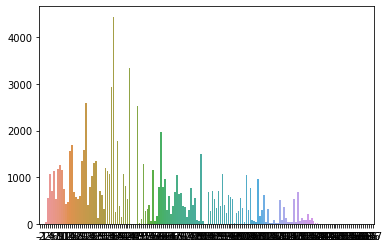

In [21]:
sns.barplot(list(sorted(recipient.keys())), list(recipient.values()))

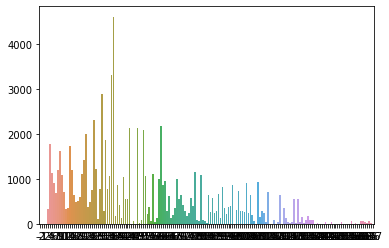

In [22]:
sns.barplot(list(sorted(sender.keys())), list(sender.values()))

In [23]:
recipient[1], sender[1]

(0, 2)

In [24]:
recipient[12], sender[12]

(61, 56)

In [25]:
recipient[123], sender[123]

(318, 283)

In [26]:
def set_sender_recipient_attrs(G):
    for node in G.nodes:
        nx.set_node_attributes(G, {node: {'sender': sender[node], 'recipient': recipient[node]}})

In [27]:
set_sender_recipient_attrs(G_reportsto)
set_sender_recipient_attrs(G_communication)
set_sender_recipient_attrs(G_both)

# Reportsto analysis

In [28]:
reporter_nums = {}

for i in range(-2, 168):
    reporter_nums[i] = 0

for group, row in reportsto.groupby(by=["ReportsToID"]):
    reporter_nums[group] = row["ID"].count()

reporter_nums

{-2: 6,
 -1: 7,
 0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 2,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 5,
 28: 0,
 29: 4,
 30: 0,
 31: 1,
 32: 0,
 33: 2,
 34: 0,
 35: 0,
 36: 9,
 37: 0,
 38: 0,
 39: 8,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 1,
 46: 0,
 47: 2,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 8,
 70: 7,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 4,
 77: 2,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 7,
 86: 12,
 87: 0,
 88: 0,
 89: 0,
 90: 7,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 13,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 2,
 119: 0,
 120: 0,
 12

In [29]:
def set_reporters_attrs(G):
    for node in G.nodes:
        nx.set_node_attributes(G, {node: {'reporters': reporter_nums[node]}})

In [30]:
set_reporters_attrs(G_reportsto)
set_reporters_attrs(G_communication)
set_reporters_attrs(G_both)

# Other static attributes

In [31]:
def set_centrality_attrs(G, func, name):
    centrality = func(G)
    for key, value in centrality.items():
        centrality[key] = {name: value}
    nx.set_node_attributes(G, centrality)

In [32]:
for G in [G_reportsto, G_communication, G_both]:
    set_centrality_attrs(G, nx.betweenness_centrality, 'betweenness')
    set_centrality_attrs(G, nx.degree_centrality, 'degree')
    set_centrality_attrs(G, nx.eigenvector_centrality, 'eigenvector')
    set_centrality_attrs(G, nx.closeness_centrality, 'closeness')
    set_centrality_attrs(G, nx.load_centrality, 'load')
    set_centrality_attrs(G, nx.harmonic_centrality, 'harmonic')
    set_centrality_attrs(G, nx.subgraph_centrality, 'subgraph')

In [33]:
G = G_both
for node in G.nodes:
    print(node, G.nodes[node])

17 {'true_class': 0, 'node': 17, 'sender': 2086, 'recipient': 1290, 'reporters': 0, 'betweenness': 0.04212366403639519, 'degree': 0.7797619047619048, 'eigenvector': 0.1693444481913132, 'closeness': 0.8115942028985508, 'load': 0.04155455940429392, 'harmonic': 149.16666666666669, 'subgraph': 7.621467088909682e+24}
39 {'true_class': 0, 'node': 39, 'sender': 1077, 'recipient': 1157, 'reporters': 8, 'betweenness': 0.019609014801967778, 'degree': 0.494047619047619, 'eigenvector': 0.12615075152178218, 'closeness': 0.65625, 'load': 0.02035435628174078, 'harmonic': 124.99999999999999, 'subgraph': 4.229405752314131e+24}
112 {'true_class': 0, 'node': 112, 'sender': 545, 'recipient': 542, 'reporters': 0, 'betweenness': 0.002387098364208051, 'degree': 0.2976190476190476, 'eigenvector': 0.08103919399259761, 'closeness': 0.5526315789473685, 'load': 0.0023972849484973444, 'harmonic': 106.08333333333326, 'subgraph': 1.7453864333170358e+24}
77 {'true_class': 0, 'node': 77, 'sender': 494, 'recipient': 58

# Save all networks

In [34]:
with open("G_reportsto.pkl", "wb") as f:
    pickle.dump(G_reportsto, file=f)

In [35]:
with open("G_communication.pkl", "wb") as f:
    pickle.dump(G_communication, file=f)

In [36]:
with open("G_both.pkl", "wb") as f:
    pickle.dump(G_both, file=f)